In [1]:
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from dinov2_feature_extraction import load_model, get_dense_descriptor
from skimage import io

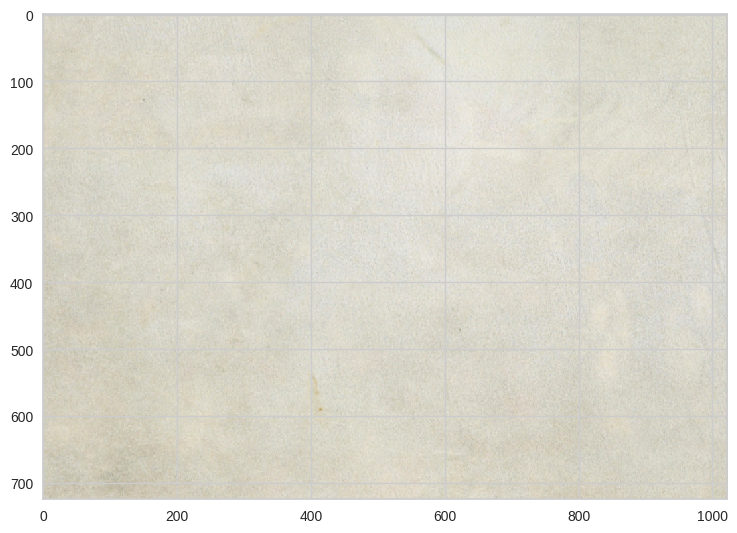

In [2]:
dataset_path_white_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page27.jpg'   
#dataset_path_white_img_2 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page1328.jpg'   
img = io.imread(dataset_path_white_img_1)
io.imshow(img)
io.show()

In [3]:
dinov2_sizes = {"small": 384,
                "base": 768,
                "large": 1024,
                "giant": 1536} # tamaños del feature vector de cada version de dinov2

backbone_size = 'small'
model = load_model(backbone_size)

Using cache found in /home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
from sklearn.decomposition import PCA

features, attention, grid_shape = get_dense_descriptor(model, img)
print(attention.shape)
print(features.shape)
# Primero, aplicas PCA a tus características originales para reducir la dimensionalidad
pca = PCA(n_components=3)
pca_fitted = pca.fit(attention) 
pca_features = pca.transform(attention)  

(3723, 384)
(3723, 384)


/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

Optimal number of clusters: 6


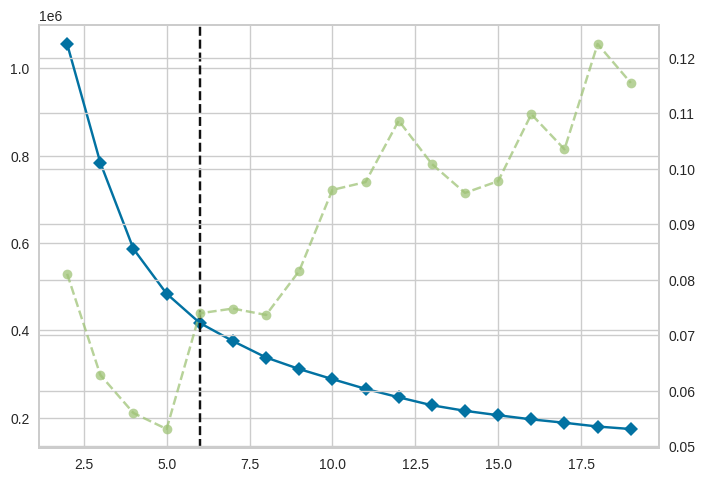

In [5]:
from sklearn.decomposition import PCA

# Initialize the KMeans model
model_kmeans = KMeans()

# Initialize the KElbowVisualizer with the number of clusters and the metric you want to use
visualizer = KElbowVisualizer(model_kmeans, k=(2,20))

# Fit the data to the visualizer
visualizer.fit(pca_features)  

# Get the optimal number of clusters
optimal_clusters = visualizer.elbow_value_

print("Optimal number of clusters:", optimal_clusters)

/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


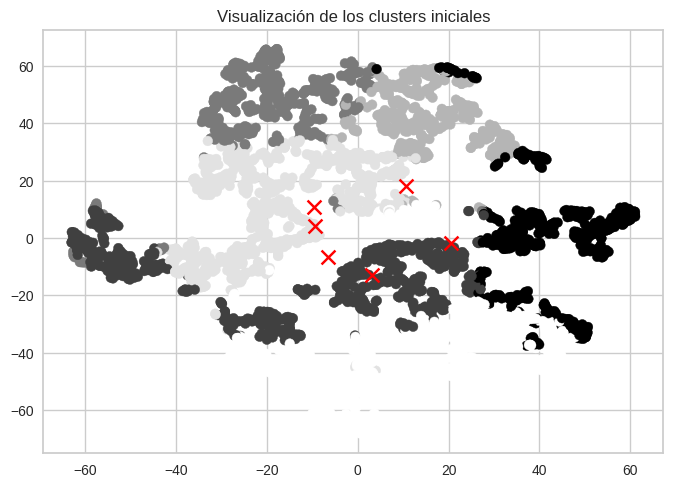

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

number_of_clusters = optimal_clusters

# Luego ajustas K-means a estas características transformadas por PCA
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
kmeans.fit(pca_features)

# Guardas los centros de los clústeres
cluster_centers = kmeans.cluster_centers_

# Ahora para visualizar los clusters iniciales
reduced_data = TSNE(n_components=2).fit_transform(pca_features)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, marker='x')  # Centros de clusters
plt.title('Visualización de los clusters iniciales')
plt.show()


In [7]:
from sklearn.metrics import pairwise_distances
from dinov2_feature_extraction import min_max_scale, get_dense_descriptor


def pca_colorize_2(features, output_shape, clusters, threshold, pca, remove_bg=True):
    pca_components = pca.transform(features)
    pca_components = min_max_scale(pca_components)
    rgb = pca_components.reshape(output_shape + (3,))

    if remove_bg:
        # Calcula la distancia entre cada punto de características y los centroides de los clusters
        distances = pairwise_distances(pca_components, clusters)

        # Calcula la suma de las distancias a todos los centroides para cada punto
        sum_distances = np.min(distances, axis=1)

        # Reestructura la matriz de sumas de distancias para que coincida con el formato de los componentes de PCA
        sum_distances = sum_distances.reshape(output_shape)

        # Crea una máscara basada en un umbral de distancia
        distance_mask = sum_distances < threshold

        # Aplica la máscara a todos los canales para eliminar los píxeles cercanos a los centros del cluster
        for c in range(3):
            rgb[distance_mask, c] = 0

        # Reescala los valores de la imagen
        rgb = min_max_scale(rgb)

    return rgb


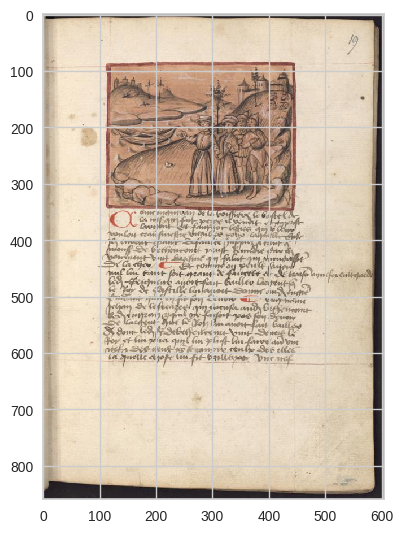

In [15]:
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page1.jpg'  
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page4.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page40.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page114.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page104.jpg'   
dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page12.jpg'  
new_img = io.imread(dataset_path_new_img_1)


new_image_features, new_image_attention, new_image_grid_shape = get_dense_descriptor(model, new_img)

io.imshow(new_img)
io.show()

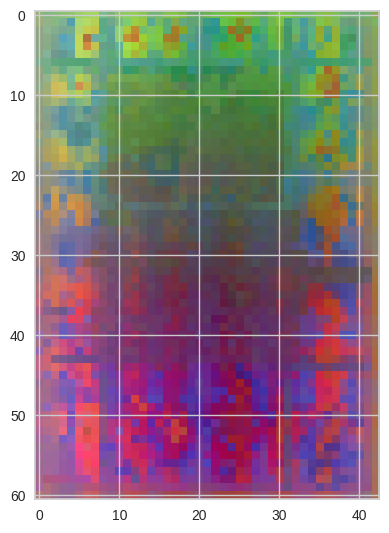

'\ntest_mask = foreground_mask(test, use_bbox=False)\nio.imshow(test_mask)\nio.show()\n\ntest_mask_box = foreground_mask(test, use_bbox=True)\nio.imshow(test_mask_box)\nio.show()\n'

In [16]:
# Process the image and get the background component

threshold = 11
test = pca_colorize_2(new_image_attention, new_image_grid_shape, cluster_centers, threshold, pca_fitted)
io.imshow(test)
io.show()

'''
test_mask = foreground_mask(test, use_bbox=False)
io.imshow(test_mask)
io.show()

test_mask_box = foreground_mask(test, use_bbox=True)
io.imshow(test_mask_box)
io.show()
'''



In [10]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image

def pca_component_images(features, output_shape, pca):
    pca_components = pca.transform(features)

    # Función para escalar y convertir un componente en una imagen
    def component_to_image(component):
        component_scaled = (component - np.min(component)) / (np.max(component) - np.min(component))
        component_scaled = (component_scaled * 255).astype(np.uint8)
        return Image.fromarray(component_scaled.reshape(output_shape))

    # Convertir cada componente en una imagen
    image1 = component_to_image(pca_components[:, 0])
    image2 = component_to_image(pca_components[:, 1])
    image3 = component_to_image(pca_components[:, 2])

    return image1, image2, image3

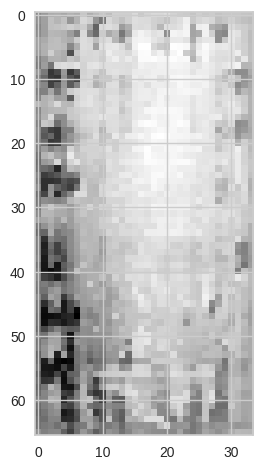

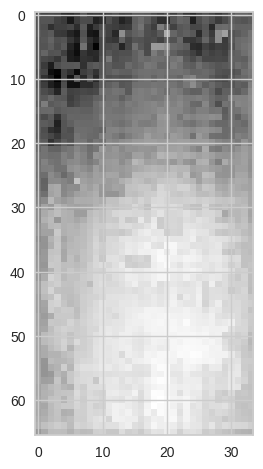

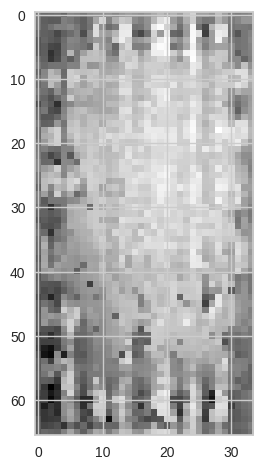

In [11]:
test1, test2, test3 = pca_component_images(new_image_attention, new_image_grid_shape, pca_fitted)
test1_array = np.array(test1)
test2_array = np.array(test2)
test3_array = np.array(test3)

# Ahora puedes utilizar plt.imshow para mostrar las imágenes
plt.imshow(test1_array)
plt.show()
plt.imshow(test2_array)
plt.show()
plt.imshow(test3_array)
plt.show()